In [4]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.structured import *
from fastai.column_data import *
import ast
import random

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
PATH = Path("../data/titanic")
TRAIN_CSV = PATH/"train.csv"
TEST_CSV = PATH/"test.csv"

14.4542

In [6]:
def clean_df(data):
    data.columns = [name.lower() for name in data.columns]

    def strip_name(name):
        return name.split(",")[1].strip().split(" ")[0][:-1]
    data["title"] = data.name.apply(strip_name)
    drop_titles = (data.title.value_counts() < 10)
    data.title = data["title"].apply(lambda x: "Misc" if drop_titles.loc[x] == True else x)
    
    data["age"].fillna(data["age"].median(), inplace=True)
    data["embarked"].fillna(data["embarked"].mode()[0], inplace=True)
    data["fare"].fillna(data["fare"].mode()[0], inplace=True)
    drops = ["passengerid", "name", "cabin", "ticket"]
    data.drop(drops, axis=1,inplace=True)

    data["famsize"] = data["sibsp"] + data["parch"] + 1
    data["alone"] = 1
    data.loc[data["famsize"] > 1, "alone"] = 0
    data["farebin"] = pd.qcut(data["fare"], 4)
    data["agebin"] = pd.cut(data["age"].astype(int), 5)
    data["pclass"] = data.pclass.astype("category")

    cat_vars = ["pclass", "sex", "embarked","title","farebin","agebin"]
    train_cats(data)
    
    
    return data, cat_vars
data = pd.read_csv(TRAIN_CSV)
data, cat_vars = clean_df(data)

tstdata = pd.read_csv(TEST_CSV)
tstdf, _ = clean_df(tstdata)

tvdata = data[:-89].copy()
tdata = data[-89:].copy()

tvdata.describe(include="all")

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title,famsize,alone,farebin,agebin
count,802.000000,802.0,802,802.000000,802.000000,802.000000,802.000000,802,802,802.000000,802.000000,802,802
unique,NaN,3.0,2,NaN,NaN,NaN,NaN,3,5,NaN,NaN,4,5
top,NaN,3.0,male,NaN,NaN,NaN,NaN,S,Mr,NaN,NaN,"(14.454, 31.0]","(16.0, 32.0]"
freq,NaN,439.0,518,NaN,NaN,NaN,NaN,580,469,NaN,NaN,206,476
mean,0.385287,NaN,NaN,29.497406,0.518703,0.374065,33.005086,NaN,NaN,1.892768,0.600998,NaN,NaN
std,0.486967,NaN,NaN,12.982958,1.062480,0.800889,51.466003,NaN,NaN,1.571746,0.489999,NaN,NaN
min,0.000000,NaN,NaN,0.670000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,NaN,NaN
25%,0.000000,NaN,NaN,22.000000,0.000000,0.000000,7.925000,NaN,NaN,1.000000,0.000000,NaN,NaN
50%,0.000000,NaN,NaN,28.000000,0.000000,0.000000,14.500000,NaN,NaN,1.000000,1.000000,NaN,NaN
75%,1.000000,NaN,NaN,35.000000,1.000000,0.000000,31.206250,NaN,NaN,2.000000,1.000000,NaN,NaN


In [7]:
df, yl, nas, mapper = proc_df(tvdata, y_fld="survived", do_scale=True)
df_test, _, nas, mapper = proc_df(tdata,y_fld="survived", do_scale=True, mapper=mapper, na_dict=nas)
val_idxs = get_cv_idxs(len(tvdata))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, yl)

In [62]:
df, yl, nas, mapper = proc_df(data, y_fld="survived", do_scale=True)
df_test, truth, nas, mapper = proc_df(tstdf, do_scale=True, mapper=mapper, na_dict=nas)

val_idxs = get_cv_idxs(len(data))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, yl)

In [63]:
cat_sz = [(c, len(tvdata[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; cat_sz, emb_szs

([('pclass', 4),
  ('sex', 3),
  ('embarked', 4),
  ('title', 6),
  ('farebin', 5),
  ('agebin', 6)],
 [(4, 2), (3, 2), (4, 2), (6, 3), (5, 3), (6, 3)])

In [64]:
md = ColumnarModelData.from_data_frame(PATH, val_idxs, df, yl.astype(np.float32), cat_flds=cat_vars, bs=32, test_df=df_test)

In [65]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=[0,1])

epoch      trn_loss   val_loss                              
    0      0.23888    0.219101  



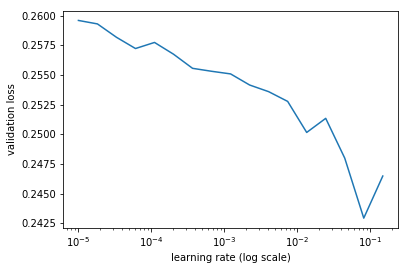

In [48]:
m.lr_find()
m.sched.plot(0)

In [49]:
lr = 3e-3

In [16]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [74]:
m.fit(lr,1, cycle_len=7, metrics=[exp_rmspe],use_clr=(20,10))

epoch      trn_loss   val_loss   exp_rmspe                  
    0      0.116416   0.153652   0.416154  
    1      0.118732   0.134917   0.433096                   
    2      0.114457   0.133734   0.448582                   
    3      0.110826   0.125738   0.415447                   
    4      0.111674   0.125631   0.419149                   
    5      0.107995   0.129036   0.436335                   
    6      0.106161   0.126309   0.424915                   



[array([0.12631]), 0.4249146224999225]

In [71]:
x,y=m.predict_with_targs()

In [72]:
exp_rmspe(x,y)

0.41140011685411004

In [70]:
preds = m.predict(is_test=True)

RuntimeError: running_mean should contain 7 elements not 6

In [68]:
def to_classes(x):
#     act =[]
#     for p in x:
#         if p > 0.5:
#             cl = 1
#         else:
#             cl = 0
#         act.append(cl)
#     return act

    return [1 if p > .5 else 0 for p in x]
pred = to_classes(preds)

RuntimeError: running_mean should contain 7 elements not 6

In [60]:
tdata["preds"] = pred

ValueError: Length of values does not match length of index

In [59]:
tstdf.loc[:,["preds","survived"]]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,preds,survived
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
5,0,NaN
6,1,NaN
7,0,NaN
8,1,NaN
9,0,NaN


418